# Import

In [ ]:
from stravalib import Client
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define

In [2]:
VERBOSE = True

# Activate API (`ONLY RUN THIS SECTION ONCE`)

In [3]:
client = Client()
url = client.authorization_url(
    client_id=157889,
    redirect_uri="http://localhost:5000/authorization",
)

if VERBOSE:
    print("Paste this URL on web browser and copy the string after 'code=...'")
    print(url)

Paste this URL on web browser and copy the string after 'code=...'
https://www.strava.com/oauth/authorize?client_id=157889&redirect_uri=http%3A%2F%2Flocalhost%3A5000%2Fauthorization&approval_prompt=auto&scope=read%2Cactivity%3Aread&response_type=code


In [5]:
token_response = client.exchange_code_for_token(
    client_id=157889, client_secret="c706246b4920e85a8244a26b5e1324d95f787bce", code="cb6d9e9ffe9a44cc5f06cba5b2e16e54282e6c50" #COPY PASTED CODE HERE
)

STORED_ACCESS_TOKEN = token_response["access_token"]
STORED_REFRESH_TOKEN = token_response["refresh_token"]  # You will need this in 6 hours if you want to stay connected

# To understand: treatment of 1 activity stream

### Download and plot activity stream

In [12]:
stream = client.get_activity_streams(
    11943455818, 
    types=[
        "time",
        "distance",
        "altitude",
        "heartrate"
    ],
    resolution="high",
    series_type="time",
)

# Sample data
time = np.array(stream["time"].data)
distance = np.array(stream["distance"].data)
altitude = np.array(stream["altitude"].data)
heartrate = np.array(stream["heartrate"].data)

# Compute instantaneous speed (m/s to km/h)
delta_dist = np.diff(distance)
delta_time = np.diff(time)
speed = (delta_dist / delta_time) * 3.6

# Compute elevation gain (in D+ meters per km of distance ran)
elevation_gain = np.diff(altitude) / delta_dist * 1000
distance_mid = (distance[1:] + distance[:-1]) / 2

# align all array lenghts
time = time[1:]
distance = distance[1:]
altitude = altitude[1:]
heartrate = heartrate[1:]

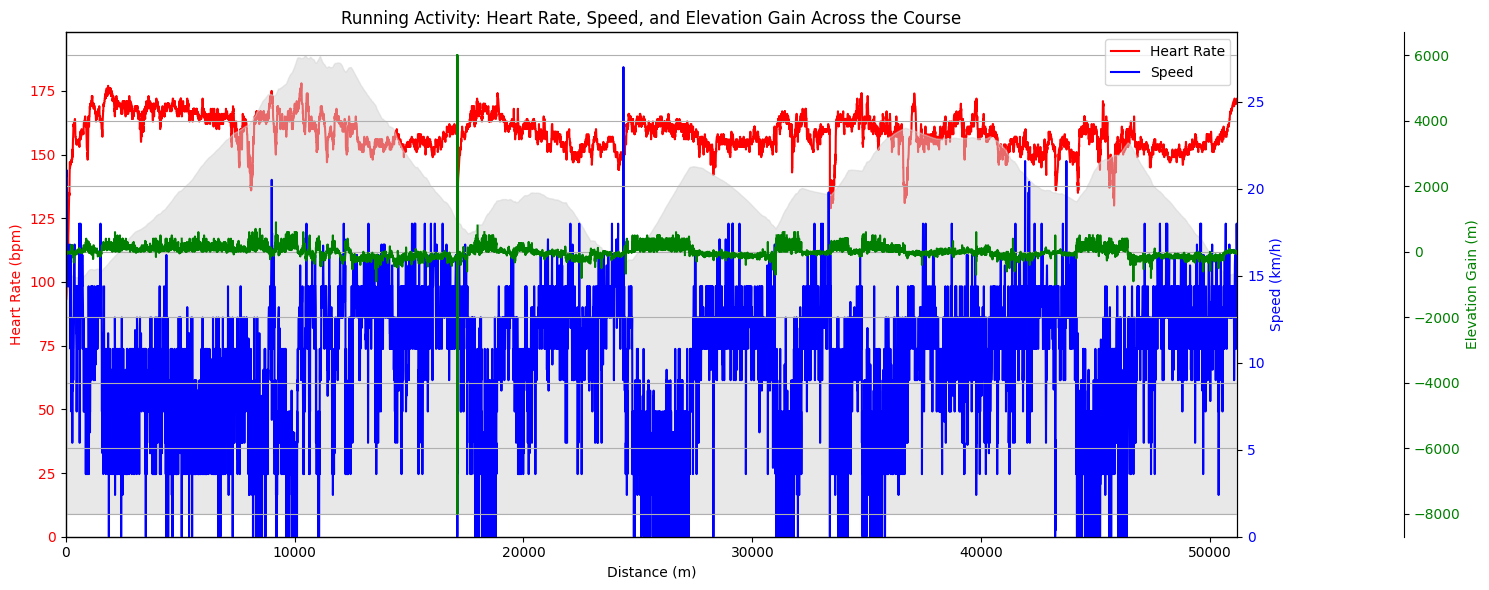

In [13]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# --- Altitude as background fill (ax3, hidden) ---
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.spines['right'].set_visible(False)
ax3.tick_params(axis='y', colors='none')
ax3.set_yticklabels([])
ax3.fill_between(distance, altitude, color="lightgray", alpha=0.5, label='Altitude', zorder=1)

# --- Heart rate (ax1) ---
ax1.plot(distance, heartrate, color="red", label='Heart Rate', zorder=2)
ax1.set_xlim([0, distance[-1]])
ax1.set_ylim([0, np.max(heartrate) + 20])
ax1.set_xlabel('Distance (m)')
ax1.set_ylabel('Heart Rate (bpm)', color='red')
ax1.tick_params(axis='y', labelcolor='red')

# --- Speed (ax2) ---
ax2 = ax1.twinx()
ax2.plot(distance, speed, color="blue", label='Speed')
ax2.set_ylim([0, np.nanmax(speed) + 2])
ax2.set_ylabel('Speed (km/h)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# --- Elevation gain (ax4) ---
ax4 = ax1.twinx()
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(distance_mid, elevation_gain, color="green", label="Elevation Gain", linewidth=1.5)
ax4.set_ylabel("Elevation Gain (m)", color="green")
ax4.tick_params(axis='y', labelcolor='green')

# --- Final touches ---
plt.title('Running Activity: Heart Rate, Speed, and Elevation Gain Across the Course')
fig.tight_layout()
plt.grid(True)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines4, labels4 = ax4.get_legend_handles_labels()
plt.legend(lines1 + lines2 + labels4, labels1 + labels2 + labels4, loc='upper right')

plt.show()

We can see that for pretty close heart rate levels, speed varies greatly depending on elevation gain. We want to be able to compare these speeds nevertheless. To do so we can introduce what is known as `gradient adjusted paste (GAP)`.

GAP is the measure of your speed `if you were running on a perfectly flat surface`. In order to calculate it, we will build a ML model that estimates this value given all of the athlete's historical data.

For this we need the data to be pre-processed in the most efficient wqy possible. We will explore the best method possible using this example before applying it to all of our data.

### Explore the best data pre-processing method

In [14]:
# cut borders
# We can see that the beginning of an activity can be a bit biased, either because the body is warming up or even simply because the watch is not working well.
# So we will cut the 2 first 15 minutes.

idx_cut = (time < 60 * 15).sum()
distance = distance[idx_cut:]

heartrate = heartrate[idx_cut:]
speed = speed[idx_cut:]
elevation_gain = elevation_gain[idx_cut:]

In [15]:
# aggregate data by 20m splits and eliminate points where there is a too important variation in elevation gain.
# the logic behind this second rule is that points where you vary ups and downs will appear as if they come from flats, which is incorrect.

threshold = 20

# find indices where used to aggregate by 20m splits
distance_downsampled = []
cuts = []
current_idx = 0
for i in range(1, len(distance)):
    if distance[i] - distance[current_idx] >= threshold:
        segment_sum = distance[i]
        distance_downsampled.append(segment_sum)
        cuts.append(i)
        current_idx = i
distance_downsampled = np.array(distance_downsampled)
print("distance_downsampled:", distance_downsampled)

# apply aggregation to speed
speed_downsampled = []
current_idx = 0
for cut_idx in cuts:
    speed_downsampled.append(speed[current_idx:cut_idx].mean())
    current_idx = cut_idx
speed_downsampled = np.array(speed_downsampled)
print("speed_downsampled:", speed_downsampled)

# apply aggregation to heartrate
heartrate_downsampled = []
current_idx = 0
for cut_idx in cuts:
    heartrate_downsampled.append(heartrate[current_idx:cut_idx].mean())
    current_idx = cut_idx
heartrate_downsampled = np.array(heartrate_downsampled)
print("heartrate_downsampled:", heartrate_downsampled)

# apply aggregation to elevation_gain AND collect indices of the new downsampled series which we will exclude afterwards because they contain ups and downs
elevation_gain_downsampled = []
up_and_down_indices = []
current_idx = 0
for cut_idx in cuts:
    elevation_gain_downsampled.append(elevation_gain[current_idx:cut_idx].mean())
    if np.any(elevation_gain[current_idx:cut_idx] > 0) and np.any(elevation_gain[current_idx:cut_idx] < 0):
        up_and_down_indices.append(len(elevation_gain_downsampled)-1)
    current_idx = cut_idx
elevation_gain_downsampled = np.array(elevation_gain_downsampled)
up_and_down_indices = np.array(up_and_down_indices)
print("elevation_gain_downsampled:", elevation_gain_downsampled)

distance_downsampled: [ 2022.  2043.  2065. ... 51129. 51151. 51174.]
speed_downsampled: [ 8.1   6.72  7.08 ... 14.4  13.2  16.2 ]
heartrate_downsampled: [174.  173.6 171.8 ... 170.  171.  170.5]
elevation_gain_downsampled: [160.         112.85714286 108.57142857 ... -12.5        -16.66666667
 -55.        ]


In [16]:
# Use downsampled data as new reference
distance = distance_downsampled
speed = speed_downsampled
heartrate = heartrate_downsampled
elevation_gain = elevation_gain_downsampled

In [17]:
# exclude the datapoints with both ups and down

print(f"Percentage of points lost = {round(len(up_and_down_indices) / len(elevation_gain) * 100)}%")

mask = np.zeros(len(distance), dtype=bool)
mask[up_and_down_indices] = True

distance = distance[~mask]
heartrate = heartrate[~mask]
speed = speed[~mask]
elevation_gain = elevation_gain[~mask]

Percentage of points lost = 11%


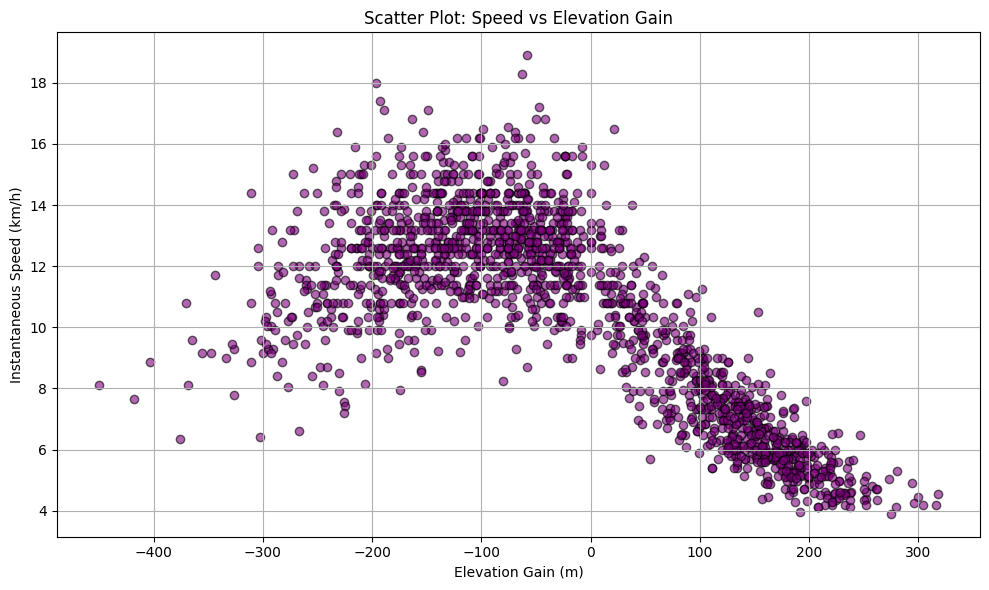

In [18]:
# To have an idea of the quality of our data, we will plot speed compared to elevation gain.
# This is only a partial test as it does not take heart rate into acoount

# Make a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(elevation_gain, speed, alpha=0.6, color='purple', edgecolor='k')
plt.xlabel("Elevation Gain (m)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Scatter Plot: Speed vs Elevation Gain")
plt.grid(True)
plt.tight_layout()
plt.show()

Finally, in order to anticipate issues and because we should have enough points in general, we will set some physical rules to delete outliers:
- Anything outside of the [-350m, +350m] of elevation gain per km is unlikely, so we will delete these points.
- Anything bellow 3km/h is also very unlikely, and even if they are correct, these points probably come from moment where the athlete is not in movement. For example, the athete could be at a life base.
- Anything above 22km/h is also very unlikely for most athletes. For pro athletes taking these speeds out would be a problem, but for most people this is a good upper bound.

In [19]:
# Delete outliers as explained above
mask = (elevation_gain >= -350) * (elevation_gain <= 350) * (speed >= 3) * (speed <= 22)

print(f"Percentage of points lost = {round(sum(~mask) / len(elevation_gain) * 100)}%")

distance = distance[mask]
heartrate = heartrate[mask]
speed = speed[mask]
elevation_gain = elevation_gain[mask]

Percentage of points lost = 12%


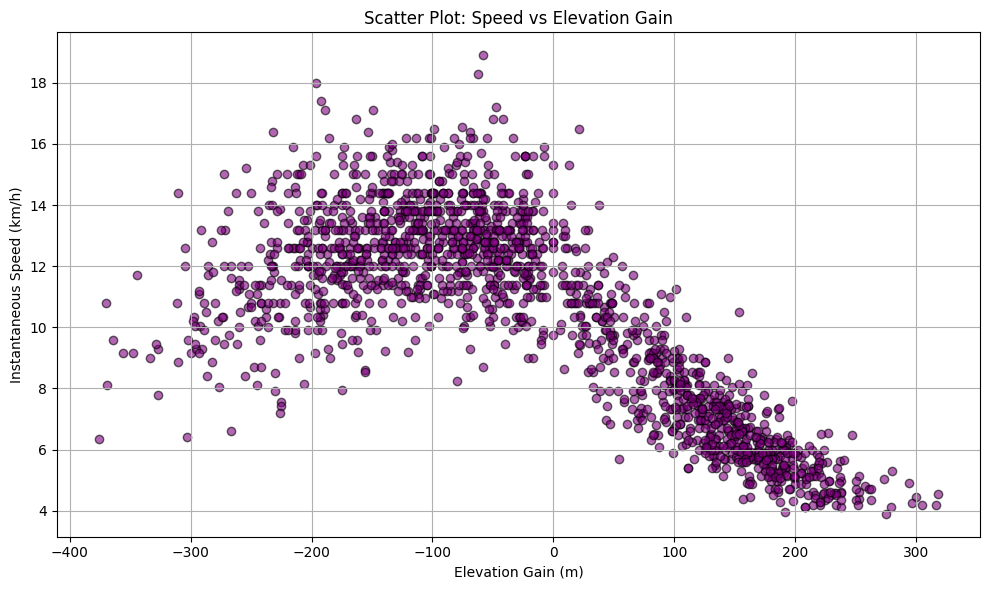

In [20]:
# plot the same plot again

plt.figure(figsize=(10, 6))
plt.scatter(elevation_gain, speed, alpha=0.6, color='purple', edgecolor='k')
plt.xlabel("Elevation Gain (m)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Scatter Plot: Speed vs Elevation Gain")
plt.grid(True)
plt.tight_layout()
plt.show()

The last plot we can try to check our data is plotting speed by heartrate while using a heatmap for point color depending on elevation_gain.

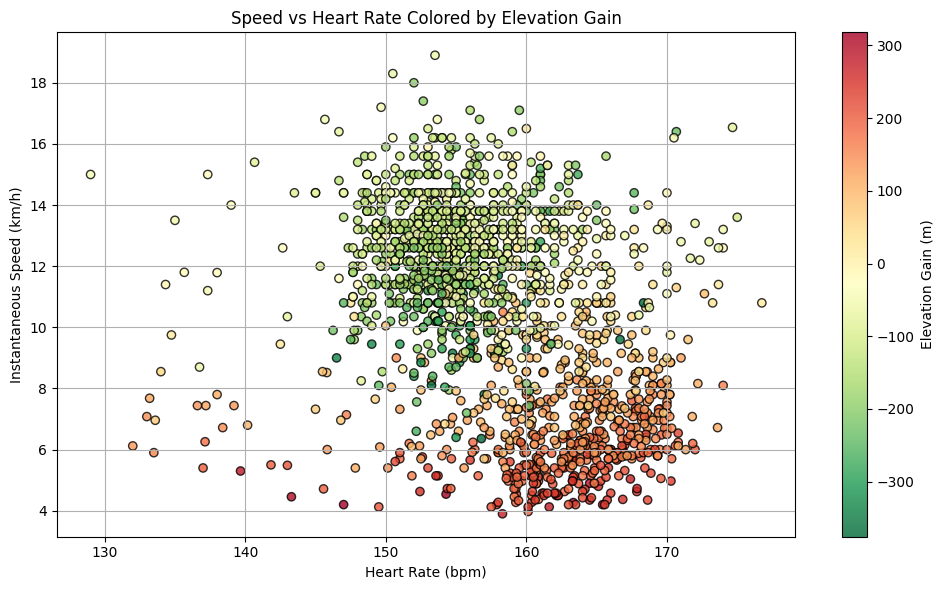

In [21]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sc = plt.scatter(
    heartrate, 
    speed,
    c=elevation_gain,
    cmap='RdYlGn_r',
    edgecolor='k',
    alpha=0.8
)

# Add colorbar to show what elevation gain the colors represent
cbar = plt.colorbar(sc)
cbar.set_label('Elevation Gain (m)')

# Labels and title
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Instantaneous Speed (km/h)")
plt.title("Speed vs Heart Rate Colored by Elevation Gain")
plt.grid(True)
plt.tight_layout()
plt.show()

We can indeed see that at a given heart rate, lower speeds correspond to higher elevation gains.

# END OF NOTEBOOK